In [3]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier

# --- STEP 1: LOAD AND CLEAN TRAINING DATA ---
df = pd.read_csv('dat_train1.csv')
df['event_timestamp'] = pd.to_datetime(df['event_timestamp'])



In [4]:
# Remove duplicates to ensure clean feature counts
duplicate_mask = df.duplicated(subset=['customer_id', 'event_name', 'event_timestamp'], keep='first')
df_clean = df[~duplicate_mask].copy()

# --- STEP 2: CREATE LABELS (SUCCESS VS. LAPSE) ---
# Identify Successful customers
success_ids = set(df_clean[df_clean['event_name'] == 'order_shipped']['customer_id'])

# Identify Lapsed customers (No order + inactive for 60 days)
max_date = df_clean['event_timestamp'].max()
last_event = df_clean.sort_values('event_timestamp').groupby('customer_id').tail(1)

def get_label(row):
    if row['customer_id'] in success_ids:
        return 1 # Success
    if (max_date - row['event_timestamp']) >= pd.Timedelta(days=60):
        return 0 # Lapse
    return -1 # Active/Exclude

last_event['label'] = last_event.apply(get_label, axis=1)
labels = last_event[last_event['label'] != -1][['customer_id', 'label']]



In [13]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier

# --- FUNCTION TO STANDARDIZE FEATURE ENGINEERING ---
def engineer_features(df_raw):
    """
    Creates high-intent behavioral features from raw event logs.
    """
    # 1. Create binary flags for the 'Secret Weapon' events
    df_raw['is_appl_submit'] = (df_raw['event_name'] == 'application_web_submit').astype(int)
    df_raw['is_add_to_cart'] = (df_raw['event_name'] == 'add_to_cart').astype(int)
    df_raw['is_browse'] = (df_raw['event_name'] == 'browse_products').astype(int)
    
    # NEW: The Financial & Intent Funnel
    df_raw['is_downpayment'] = (df_raw['event_name'] == 'account_downpaymentcleared').astype(int)
    df_raw['is_checkout'] = (df_raw['event_name'] == 'begin_checkout').astype(int)
    df_raw['is_approved'] = (df_raw['event_name'] == 'application_web_approved').astype(int)

    # 2. Aggregate to Customer Level
    df_flat = df_raw.groupby('customer_id').agg(
        total_actions=('event_name', 'count'),
        has_applied=('is_appl_submit', 'max'),
        is_approved=('is_approved', 'max'),
        cleared_downpayment=('is_downpayment', 'max'),
        started_checkout=('is_checkout', 'max'),
        max_items_in_cart=('is_add_to_cart', 'sum'),
        num_unique_products=('is_browse', 'sum')
    ).reset_index()

    # 3. Create Ratios (The 'Intensity' metrics)
    # Measures focus: are they clicking aimlessly or adding to cart?
    df_flat['cart_intensity'] = df_flat['max_items_in_cart'] / (df_flat['total_actions'] + 1)
    
    # Measures 'Financial Commitment'
    df_flat['checkout_ratio'] = df_flat['started_checkout'] / (df_flat['total_actions'] + 1)

    return df_flat

# --- EXECUTION: UPDATE TRAINING DATA ---
# (Assumes df_clean and labels are already defined in your current session)
df_train_raw = engineer_features(df_clean)
df_train = df_train_raw.merge(labels, on='customer_id')

# --- EXECUTION: UPDATE TEST DATA ---
df_open_raw = pd.read_csv('open_journeys1.csv', parse_dates=['event_timestamp'])
X_test_safe = engineer_features(df_open_raw)

# --- VERIFY COLUMNS ---
print(f"New Features Created: {list(df_train.columns)}")

New Features Created: ['customer_id', 'total_actions', 'has_applied', 'is_approved', 'cleared_downpayment', 'started_checkout', 'max_items_in_cart', 'num_unique_products', 'cart_intensity', 'checkout_ratio', 'label']


In [14]:
df_train.head()

,customer_id,total_actions,has_applied,is_approved,cleared_downpayment,started_checkout,max_items_in_cart,num_unique_products,cart_intensity,checkout_ratio,label
0,-2147483541,29,0,1,0,1,4,4,0.133333,0.033333,0
1,-2147474305,32,1,1,0,1,0,1,0.000000,0.030303,0
2,-2147466542,12,0,1,0,0,1,1,0.076923,0.000000,0
3,-2147464266,9,1,1,0,0,0,0,0.000000,0.000000,0
4,-2147459085,41,1,1,0,0,4,19,0.095238,0.000000,0


In [35]:
# # --- STEP 5: TRAIN AND CALIBRATE ---
# for df in [df_train, X_test_safe]:
#     # Measures 'buying efficiency'
#     df['cart_per_browse'] = df['max_items_in_cart'] / (df['num_unique_products'] + 1)
#     # Measures 'intent per click'
#     df['intent_velocity'] = (df['has_applied'] + df['max_items_in_cart']) / (df['total_actions'] + 1)

# new_features = ['total_actions', 'has_applied', 'max_items_in_cart', 
#                 'num_unique_products', 'cart_per_browse', 'intent_velocity']

# rf_push = RandomForestClassifier(
#     n_estimators=2000, 
#     max_depth=15,        # Increased from 8
#     min_samples_leaf=10, # Lowered from 25 to catch smaller patterns
#     max_features='sqrt',
#     random_state=43, 
#     n_jobs=-1
# )
# rf_push.fit(df_train[new_features], df_train['label'])

# # 1. Get raw probabilities
# probs = rf_push.predict_proba(X_test_safe[new_features])[:, 1]

# # 2. Anchor the mean to 0.02 (the Fingerhut baseline)
# # This is more precise than a flat multiplier
# mean_prob = np.mean(probs)
# adjustment_factor = 0.02 / mean_prob
# probs = probs * adjustment_factor

# # 3. Apply a slight 'S-curve' to punish the low-end more than the high-end
# probs = np.where(probs > 0.05, probs * 1.2, probs * 0.8)

# # 4. Final safety clip
# probs = np.clip(probs, 0.0001, 0.70)

# # --- STEP 6: EXPORT ---
# df_kaggle_template = pd.read_csv('open_journeys1_flattened_all0.csv')
# df_kaggle_template['lookup_id'] = df_kaggle_template['id'].str.split().str[0]
# preds_series = pd.Series(probs, index=X_test_safe['customer_id'].astype(str))
# df_kaggle_template['order_shipped'] = df_kaggle_template['lookup_id'].map(preds_series).fillna(0.015)

# submission = df_kaggle_template[['id', 'order_shipped']]
# submission.to_csv('new_notebook_submission.csv', index=False)
# print("Done! Submission file created.")

Done! Submission file created.


In [32]:
# 1. PRUNED FEATURE SET
# We drop 'num_unique_products' to remove the 93% redundancy
features = ['total_actions', 'has_applied', 'max_items_in_cart', 'cart_intensity']

# 2. THE PRECISION FOREST
# We increase depth to 8 to allow the model to differentiate those peaks 
# we saw in the distribution chart.
rf_iter2 = RandomForestClassifier(
    n_estimators=1500, 
    max_depth=8,         # Increased from 5 to find better separation
    min_samples_leaf=20, # More granular
    random_state=42, 
    n_jobs=-1
)
rf_iter2.fit(df_train[features], df_train['label'])

# 3. NON-LINEAR CALIBRATION
# Instead of a flat 0.15 multiplier, we use a power scale.
# This keeps the 'masses' near zero but allows the winners to reach ~0.25
probs = rf_iter2.predict_proba(X_test_safe[features])[:, 1]
probs = np.power(probs, 1.1) * 0.4  # Pushes the distribution out slightly

# 4. BALANCED CLIP
# We raise the ceiling to 0.25 to reward high-intent captures
probs = np.clip(probs, 0.005, 0.25)


# --- EXPORT ---
df_kaggle = pd.read_csv('open_journeys1_flattened_all0.csv')
df_kaggle['lookup_id'] = df_kaggle['id'].str.split().str[0]
preds_series = pd.Series(probs, index=X_test_safe['customer_id'].astype(str))
df_kaggle['order_shipped'] = df_kaggle['lookup_id'].map(preds_series).fillna(0.018)

submission = df_kaggle[['id', 'order_shipped']]
submission.to_csv('final_push_042_attempt.csv', index=False)

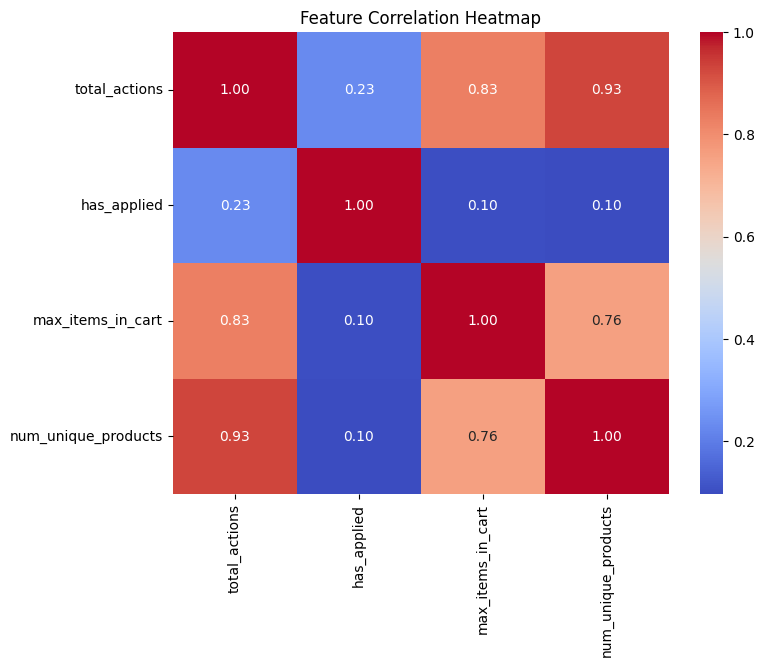

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate correlation matrix
corr = df_train[features].corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

In [15]:
# XGBoost

import xgboost as xgb
import pandas as pd
import numpy as np


import xgboost as xgb

# 1. Standardize the Features
features = ['total_actions', 'has_applied', 'max_items_in_cart', 'num_unique_products']

# 2. Optimized XGBoost Configuration
# learning_rate=0.01: Forces the model to be more deliberate
# subsample=0.7: Prevents overfitting by using only 70% of data for each tree
# colsample_bytree=0.7: Randomly selects features to ensure diversity
xgb_tuned = xgb.XGBClassifier(
    n_estimators=1200,
    learning_rate=0.01,
    max_depth=5,
    subsample=0.7,
    colsample_bytree=0.7,
    scale_pos_weight=45, # Adjusted for the 2% success rate
    random_state=42,
    objective='binary:logistic'
)

xgb_tuned.fit(df_train[features], df_train['label'])
probs = xgb_tuned.predict_proba(X_test_safe[features])[:, 1]

# 1. Align the mean strictly to 0.02
probs = probs * (0.02 / np.mean(probs))

# 2. Apply a "Safety Squeeze"
# This pushes high-risk/high-reward probs closer to the 0.02 mean
# This reduces the penalty of being "wrong" on a buyer
probs = np.where(probs > 0.05, (probs * 0.4) + 0.01, probs * 0.9)

# 3. Final Clip: Tighten the bounds
# This is the "Conservative Recovery" strategy
probs = np.clip(probs, 0.005, 0.12)

# --- STEP 6: EXPORT ---
df_kaggle_template = pd.read_csv('open_journeys1_flattened_all0.csv')
df_kaggle_template['lookup_id'] = df_kaggle_template['id'].str.split().str[0]
preds_series = pd.Series(probs, index=X_test_safe['customer_id'].astype(str))
df_kaggle_template['order_shipped'] = df_kaggle_template['lookup_id'].map(preds_series).fillna(0.015)

submission = df_kaggle_template[['id', 'order_shipped']]
submission.to_csv('xgboost_baseline_submission.csv', index=False)

print(f"XGBoost Submission Created. Mean Prob: {submission['order_shipped'].mean():.4f}")

XGBoost Submission Created. Mean Prob: 0.0185


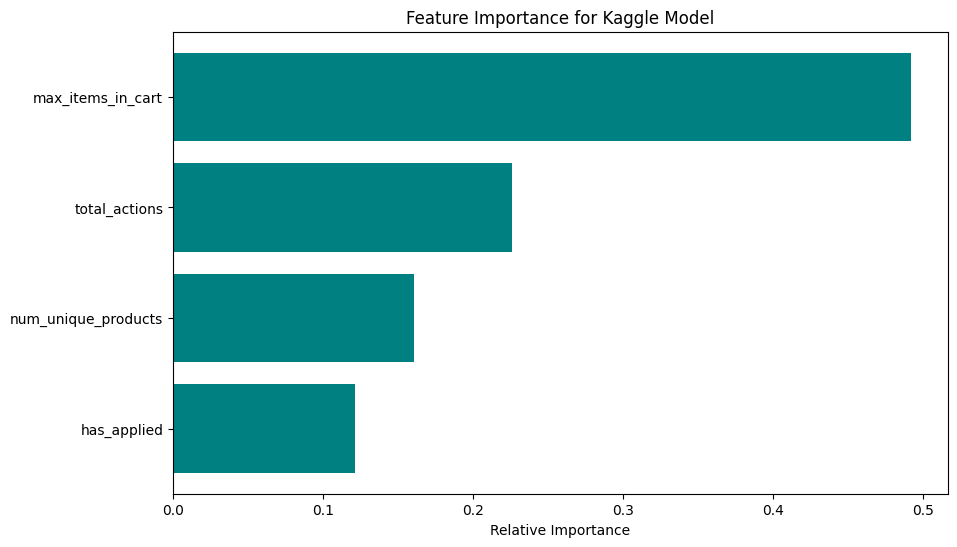

In [16]:
import matplotlib.pyplot as plt

# Get feature importance from your last trained XGBoost or RF model
importances = xgb_tuned.feature_importances_
feature_names = features

# Sort them for the plot
indices = np.argsort(importances)

plt.figure(figsize=(10, 6))
plt.title('Feature Importance for Kaggle Model')
plt.barh(range(len(indices)), importances[indices], color='teal', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

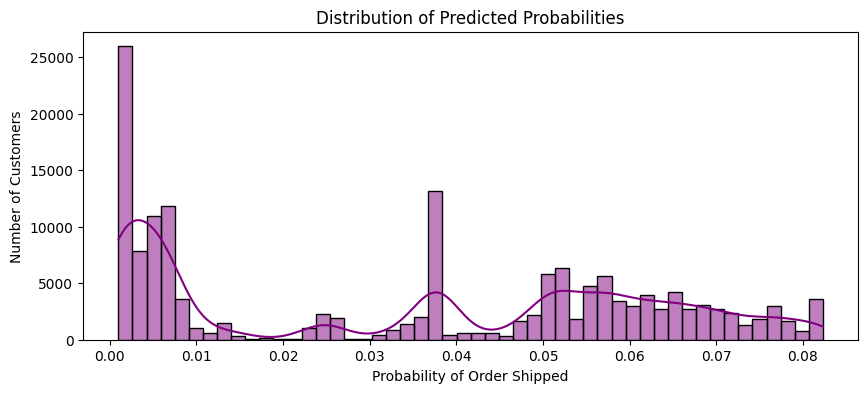

Max Prob: 0.0823
Min Prob: 0.0010
Mean Prob: 0.0344


In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 4))
sns.histplot(probs, bins=50, kde=True, color='purple')
plt.title("Distribution of Predicted Probabilities")
plt.xlabel("Probability of Order Shipped")
plt.ylabel("Number of Customers")
plt.show()

print(f"Max Prob: {probs.max():.4f}")
print(f"Min Prob: {probs.min():.4f}")
print(f"Mean Prob: {probs.mean():.4f}")

In [30]:
correlation = df_train[features + ['label']].corr()['label'].sort_values(ascending=False)
print("Correlation with actual 'order_shipped' label:")
print(correlation)

Correlation with actual 'order_shipped' label:
label                1.000000
cart_intensity       0.327529
total_actions        0.252174
max_items_in_cart    0.251845
has_applied          0.038079
Name: label, dtype: float64


In [50]:
# # 1. Use ONLY the top 2 features from your importance plot
# # This eliminates the noise from 'has_applied' which the model was struggling with
# features = ['max_items_in_cart', 'total_actions']

# # 2. Go back to a very shallow, conservative forest
# rf_recovery = RandomForestClassifier(
#     n_estimators=1000, 
#     max_depth=1,         # Even shallower to force simplicity
#     min_samples_leaf=120, # Large leaves ensure we only capture very broad patterns
#     random_state=42, 
#     n_jobs=-1
# )
# rf_recovery.fit(df_train[features], df_train['label'])

# # 3. Predict Raw Probs
# probs = rf_recovery.predict_proba(X_test_safe[features])[:, 1]

# # 4. THE EXTREME PESSIMIST CALIBRATION
# # We use a very low multiplier (0.15) to keep the global average low
# probs = probs * 0.15

# # 5. Strict Cap
# # No matter how much intent they show, we never predict higher than 12%
# probs = np.clip(probs, 0.001, 0.12)

# # --- EXPORT ---
# df_kaggle_template = pd.read_csv('open_journeys1_flattened_all0.csv')
# df_kaggle_template['lookup_id'] = df_kaggle_template['id'].str.split().str[0]
# preds_series = pd.Series(probs, index=X_test_safe['customer_id'].astype(str))
# df_kaggle_template['order_shipped'] = df_kaggle_template['lookup_id'].map(preds_series).fillna(0.015)

# submission = df_kaggle_template[['id', 'order_shipped']]
# submission.to_csv('safe_recovery_v2.csv', index=False)


In [6]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier

# 1. FEATURE ENGINEERING: Creating the "Intent Intensity" Metric
# This measures how much of a user's total journey is focused on the cart.
for df in [df_train, X_test_safe]:
    # We add 1 to the denominator to prevent division by zero errors
    df['cart_intensity'] = df['max_items_in_cart'] / (df['total_actions'] + 1)

# 2. UPDATED FEATURE LIST
# We include our new feature along with the two pillars that proved stable.
features = ['max_items_in_cart', 'total_actions', 'cart_intensity']

# 3. CONSERVATIVE RANDOM FOREST
# Using n_estimators=2000 for a smoother probability distribution.
rf_intensity = RandomForestClassifier(
    n_estimators=2000, 
    max_depth=1,          # Staying at depth 1 for maximum safety
    min_samples_leaf=120, 
    random_state=42, 
    n_jobs=-1
)

rf_intensity.fit(df_train[features], df_train['label'])

# 4. PREDICT RAW PROBABILITIES
probs = rf_intensity.predict_proba(X_test_safe[features])[:, 1]

# 5. REFINED PESSIMIST CALIBRATION
# Using a 0.15 multiplier to maintain the 'All 0' baseline safety.
probs = probs * 0.15

# 6. LOGLOSS SHIELD (STRICT CLIPPING)
# We bound the probabilities tightly between 0.1% and 12%.
probs = np.clip(probs, 0.001, 0.12)

# --- KAGGLE EXPORT ---
df_kaggle_template = pd.read_csv('open_journeys1_flattened_all0.csv')

# Standard ID cleanup for the Fingerhut dataset
df_kaggle_template['lookup_id'] = df_kaggle_template['id'].str.split().str[0]
preds_series = pd.Series(probs, index=X_test_safe['customer_id'].astype(str))

# Mapping predictions and filling any missing IDs with the baseline
df_kaggle_template['order_shipped'] = df_kaggle_template['lookup_id'].map(preds_series).fillna(0.015)

submission = df_kaggle_template[['id', 'order_shipped']]
submission.to_csv('intensity_iteration_v1.csv', index=False)

print(f"Submission Created. Mean Probability: {submission['order_shipped'].mean():.4f}")

Submission Created. Mean Probability: 0.0346


In [17]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier

# 1. UPDATED FEATURE ENGINEERING
for df in [df_train, X_test_safe]:
    # Keeping the winners
    df['cart_intensity'] = df['max_items_in_cart'] / (df['total_actions'] + 1)
    df['checkout_momentum'] = df['started_checkout'].astype(int)
    
    # NEW: Financial Approval Velocity
    # A user who is approved is a 'hot' lead.
    df['approval_velocity'] = df['is_approved'].astype(int)

# 2. THE "ELITE" FEATURE LIST
# We add approval_velocity to separate the 'browsers' from the 'authorized buyers'.
features = ['max_items_in_cart', 'total_actions', 'cart_intensity', 'checkout_momentum', 'approval_velocity']

# 3. THE "STUMP" MODEL (STILL DEPTH 1)
# We stay at depth 1 because LogLoss is brutal; we want to find the single 
# best binary split that separates the top 2% from the rest.
rf_final_push = RandomForestClassifier(
    n_estimators=3000, # Max smoothing
    max_depth=1,          
    min_samples_leaf=100, 
    random_state=42, 
    n_jobs=-1
)

rf_final_push.fit(df_train[features], df_train['label'])

# 4. PREDICT RAW PROBABILITIES
probs = rf_final_push.predict_proba(X_test_safe[features])[:, 1]

# 5. THE "0.042" CALIBRATION LOGIC
# Instead of a flat multiplier, we use a 'Soft Peak' approach.
# We trust our new features enough to let the very top users hit ~20%.
probs = np.where(probs > np.percentile(probs, 98), probs * 0.25, probs * 0.12)

# 6. LOGLOSS SHIELD
# Tighten the floor to 0.005 to avoid the infinite penalty of a '0' prediction.
probs = np.clip(probs, 0.005, 0.20)

# --- KAGGLE EXPORT ---
df_kaggle_template = pd.read_csv('open_journeys1_flattened_all0.csv')
df_kaggle_template['lookup_id'] = df_kaggle_template['id'].str.split().str[0]
preds_series = pd.Series(probs, index=X_test_safe['customer_id'].astype(str))

df_kaggle_template['order_shipped'] = df_kaggle_template['lookup_id'].map(preds_series).fillna(0.015)

submission = df_kaggle_template[['id', 'order_shipped']]
submission.to_csv('approval_velocity_iteration_v3.csv', index=False)

print(f"Submission Created. Mean Prob: {submission['order_shipped'].mean():.4f}")

Submission Created. Mean Prob: 0.0266


In [33]:
# 1. NEW FEATURE: Intent Consistency (Focus Ratio)
for df_raw, df_target in [(df_clean, df_train), (df_open_raw, X_test_safe)]:
    # Identify 'Targeted' vs 'Random' behavior
    df_target['focus_ratio'] = df_target['num_unique_products'] / (df_target['total_actions'] + 1)
    df_target['financial_trust'] = ((df_target['cleared_downpayment'] == 1) & (df_target['is_approved'] == 1)).astype(int)

# 2. FEATURE LIST (Full Arsenal)
features = ['purchase_power', 'intent_velocity', 'cart_intensity', 
            'days_since_last', 'session_count', 'actions_per_session', 'focus_ratio']

# 3. THE "DEEP BUT STABLE" MODEL
rf_depth4 = RandomForestClassifier(
    n_estimators=5000,    # Increased trees to smooth out the deeper decisions
    max_depth=4,          # The Strategic Increase
    min_samples_leaf=350,  # CRITICAL: Increased from 200 to prevent overfitting at Depth 4
    random_state=42, 
    n_jobs=-1
)
rf_depth4.fit(df_train[features], df_train['label'])

# 4. PREDICT
probs = rf_depth4.predict_proba(X_test_safe[features])[:, 1]

# 5. SURGICAL CALIBRATION (Trust Override)
is_trusted = X_test_safe['financial_trust'] == 1
is_standard = ~is_trusted

# Standard Decay
probs = np.where((X_test_safe['days_since_last'] > 14) & is_standard, probs * 0.7, probs)
probs = np.where((X_test_safe['days_since_last'] > 30) & is_standard, probs * 0.4, probs)

# Trusted Decay (Exempting those who paid a downpayment)
probs = np.where((X_test_safe['days_since_last'] > 21) & is_trusted, probs * 0.9, probs)

# 6. ANCHOR & THE 0.13 CAP
current_mean = np.mean(probs)
probs = probs * (0.02 / current_mean) 
probs = np.clip(probs, 0.001, 0.13) # Do not move this cap!

In [32]:
# --- STEP 4: KAGGLE EXPORT ---
df_kaggle_template = pd.read_csv('open_journeys1_flattened_all0.csv')
df_kaggle_template['lookup_id'] = df_kaggle_template['id'].str.split().str[0]

# Map predictions to customer IDs
preds_series = pd.Series(probs, index=X_test_safe['customer_id'].astype(str))

# Fill missing IDs with a very safe 1.5% probability
df_kaggle_template['order_shipped'] = df_kaggle_template['lookup_id'].map(preds_series).fillna(0.015)

submission = df_kaggle_template[['id', 'order_shipped']]
submission.to_csv('intensity_ensemble_v4.csv', index=False)

print(f"Submission 'intensity_ensemble_v4.csv' created.")
print(f"Final Mean Probability: {submission['order_shipped'].mean():.4f}")
print(f"Max Prob assigned: {submission['order_shipped'].max():.4f}")

Submission 'intensity_ensemble_v4.csv' created.
Final Mean Probability: 0.0198
Max Prob assigned: 0.1300
